#### Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder
from graphviz import Source
from sklearn import tree
from sklearn.naive_bayes import CategoricalNB

#### Loading data and preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/in-vehicle-coupon-recommendation.csv')

In [ ]:
df.head(3)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1


Let's have a look at the data-types of attributes

In [ ]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

Cardinality of categorical columns

In [ ]:
for col in df.columns:
    print("{} column has {} unique values".format(col,df[col].nunique()))

destination column has 3 unique values
passanger column has 4 unique values
weather column has 3 unique values
temperature column has 3 unique values
time column has 5 unique values
coupon column has 5 unique values
expiration column has 2 unique values
gender column has 2 unique values
age column has 8 unique values
maritalStatus column has 5 unique values
has_children column has 2 unique values
education column has 6 unique values
occupation column has 25 unique values
income column has 9 unique values
car column has 5 unique values
Bar column has 5 unique values
CoffeeHouse column has 5 unique values
CarryAway column has 5 unique values
RestaurantLessThan20 column has 5 unique values
Restaurant20To50 column has 5 unique values
toCoupon_GEQ5min column has 1 unique values
toCoupon_GEQ15min column has 2 unique values
toCoupon_GEQ25min column has 2 unique values
direction_same column has 2 unique values
direction_opp column has 2 unique values
Y column has 2 unique values


As we can see, even columns like temperature and age have a few unique values ,hence these columns should also be logically treated as categorical.

In [ ]:
# this code snippet finds the columns with highest cardinality for each datatype
max_int = -1
max_obj = -1
int_mc = None
obj_mc = None
for col in df.columns:
    if df[col].dtypes=='int64':
        if df[col].nunique()>max_int:
            int_mc = col
            max_int = df[col].nunique()
    if df[col].dtypes==object:
        if df[col].nunique()>max_obj:
            obj_mc = col
            max_obj = df[col].nunique()

print("Integer-Column {} has highest cardinalty of {}".format(int_mc,max_int))
print('Cat-column {} has highest cardinality of {}'.format(obj_mc,max_obj))

Integer-Column temperature has highest cardinalty of 3
Cat-column occupation has highest cardinality of 25


Since our data is very small, columns like Occupation can cause curse of dimensionality if one hot encoded.

How many nulls are there in data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

Most of the columns in data have a few missing values hence they can be imputed, car has only 108 non-null instances, so we will create another category 'missing' for NAN. We will drop it if it isn't useful later

What's the %age of missing values in each attribute?

In [ ]:
(df.isnull().sum() / (df.shape[0])) * 100

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64

More than 99% values are missing in car attribute, whereas others have around \~1% missing values only

What unique values are there in each attribute, do they make sense?

In [ ]:
for col in df.columns:
    print(col,"-->",df[col].unique())

destination --> ['No Urgent Place' 'Home' 'Work']
passanger --> ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather --> ['Sunny' 'Rainy' 'Snowy']
temperature --> [55 80 30]
time --> ['2PM' '10AM' '6PM' '7AM' '10PM']
coupon --> ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration --> ['1d' '2h']
gender --> ['Female' 'Male']
age --> ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus --> ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children --> [1 0]
education --> ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation --> ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Pers

A few attributes which are in context of coupons (CarryAway,Restaurant20To50 etc) need some renaming in values for interpretability.   
Also a few categories can be combined logically like time variable can be changed to morning, evening and night.

In [ ]:
# simple script to change values in a few columns
cols_that_need_wrangling = ['time','temperature', 'Bar',  'CoffeeHouse',  'CarryAway', 'RestaurantLessThan20','Restaurant20To50']

d_time = {
    '7AM':'Morning',
    '10AM':'Morning',
    '2PM':'Evening',
    '6PM':'Evening',
    '10PM':'Night'
}
d_temp = {
    55:'Low',
    80:'High', 
    30:'Medium'
}
d_bar = {
    'less1':'Atmost 1', 
    '1~3':'1 to 3',
    'gt8':'Greater than 8' , 
    '4~8':'4 to 8',
    'never':'never'
}
d_CoffeeHouse = {
    'less1':'Atmost 1', 
    '1~3':'1 to 3',
    'gt8':'Greater than 8' , 
    '4~8':'4 to 8',
    'never':'never'
}
d_CarryAway = {
    'less1':'Atmost 1', 
    '1~3':'1 to 3',
    'gt8':'Greater than 8' , 
    '4~8':'4 to 8',
    'never':'never'
}
d_RestaurantLessThan20 = {
    'less1':'Atmost 1', 
    '1~3':'1 to 3',
    'gt8':'Greater than 8' , 
    '4~8':'4 to 8',
    'never':'never'
}
d_Restaurant20To50 = {
    'less1':'Atmost 1', 
    '1~3':'1 to 3',
    'gt8':'Greater than 8' , 
    '4~8':'4 to 8',
    'never':'never'
}
mapping = [d_time,d_temp ,d_bar,d_CoffeeHouse,d_CarryAway,d_RestaurantLessThan20,d_Restaurant20To50]

for column,d in zip(cols_that_need_wrangling,mapping):
    df[column] = df[column].map(d)

df.expiration.replace({'1d':'24h'},inplace=True)

Since this was survey data, filled via form, all our data is properly structured and not much preprocessing is needed. We will deal with missing values at the end.    
Let's do the EDA now, and we'll revisit data wrangling as and when needed.

#### Exploratory Data Analysis (Univariate)

Q. What is the share of classes/target-var in data?

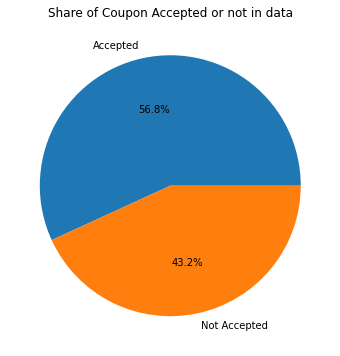

In [ ]:
# simple script to make a pie plot showing share of classes
plt.figure(figsize=(10,6))
plt.pie(df.Y.value_counts(),labels=['Accepted','Not Accepted'], autopct='%.1f%%')
plt.title("Share of Coupon Accepted or not in data")
plt.show()

We have more data on Accepted coupons than not accepted coupons.We don't suffer from severe class imbalance but balancing can be a part of the modelling experimentation.   

In [ ]:
ordinal_columns = ['temperature','expiration','age','income']   

We'll do EDA of ordinal columns first 

Q. What is the Frequency distribution of various ordinal features 

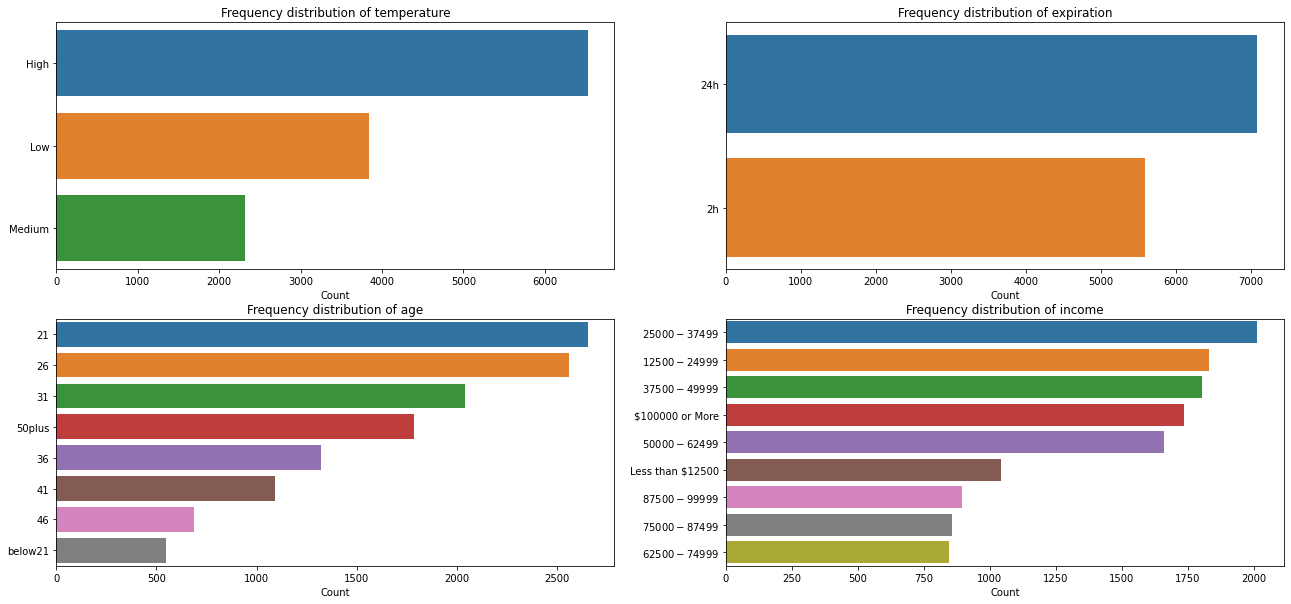

In [ ]:
def freq_plotter(nrows, ncols,figsize,cols_to_plot):
    '''
    Helper function to print countplots / frequency-distribution of each attribute
    '''
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)  # https://stackoverflow.com/questions/31726643/how-to-plot-in-multiple-subplots
    ax = ax.flatten()
    i = 0
    for col in df.columns:
        if col in cols_to_plot and col!='Y':  # we don't want to see distribution of target variable
            if df[col].dtype==np.int64:   # Any numeric column is converted to categorical first for plotting countplots
                df[col] = df[col].astype(str)
            temp = df[col].value_counts()
            sns.barplot(x=temp.values,y=temp.index,ax=ax[i])
            ax[i].set_xlabel('Count')
            ax[i].set_title('Frequency distribution of {}'.format(col))
            # plt.show()
            i += 1
freq_plotter(nrows=2, ncols=2,figsize=(22,10),cols_to_plot=ordinal_columns)

The above grid of plots shows distribution of various categorical values in our data.    
Observations:
* Temperature value is mostly high in our data. Probably most of the survey respondents lived in hot areas. Coupons with expiration time of 24h and 2h is almost same in number which is good for not introducing any coupon-type related bias in data.   
* Most of the survey respondents are in 21-31 age group and least from below-21 probably because adults are mostly outgoing (late 20's) and younger people / teens aren't allowed to drive cars since this data is from coupon recommendation system inside cars and respondent is the driver himself.
* Most people belong to lower salary ranges.

Let's compare cheap and expensive restaurants countplots side by side

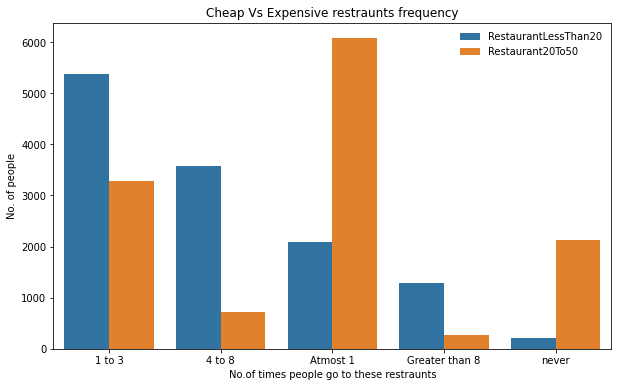

In [ ]:
# simple snippet to compare cheap and expensive restraunt responses side by side
cheap = df['RestaurantLessThan20'].value_counts()
exp = df['Restaurant20To50'].value_counts()
combine = pd.merge(cheap,exp,left_index=True,right_index=True).reset_index()   # combining frequencies of grps for cheap and expensive restaurants
final = pd.melt(combine,id_vars=['index'], value_vars=['RestaurantLessThan20','Restaurant20To50'])  # unpivoting for plotting

# plotting
plt.figure(figsize=(10,6))
sns.barplot(data=final,x='index',y='value',hue='variable')
plt.xlabel("No.of times people go to these restraunts")
plt.ylabel("No. of people")
plt.title("Cheap Vs Expensive restraunts frequency")
plt.legend(frameon=False,loc='upper right')
plt.show()

Comparing the cheap(RestaurantLessThan20) and expensive restraunts(Restaurant20To50), it is clearly evident that people rarely (Atmost 1 time) go to expensive restraunts and people mostly (1 to 3 & 4 to 8 times) prefer cheaper restraunts.    
Is it because respondents have mostly lower salary changes? Let's check

Q. Do people with more income prefer expensive restraunts?

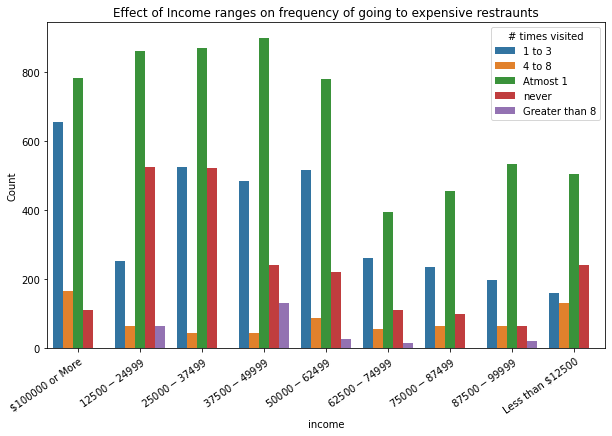

In [ ]:
temp = pd.DataFrame(df.groupby(['income','Restaurant20To50']).size()).reset_index()
temp.columns = ['income','Restaurant20To50','values']

# plotting
plt.figure(figsize=(10,6))
sns.barplot(x='income',y='values',hue='Restaurant20To50',data=temp)
plt.xticks(rotation = 35,rotation_mode = "anchor",ha = "right")
plt.ylabel("Count")
plt.title("Effect of Income ranges on frequency of going to expensive restraunts")
plt.legend(title="# times visited",loc='upper right')
plt.show()

From the above plot we can infer that irrespective of their incomes most people go to expensive restaurants 'Atmost 1' times. However, people earning **$100k or more** are more likley to visit 1-3 times as compared to others.

In [ ]:
ordinal_columns.extend(['RestaurantLessThan20','Restaurant20To50'])

Q. How do these ordinal features behave with respect to the target variable?

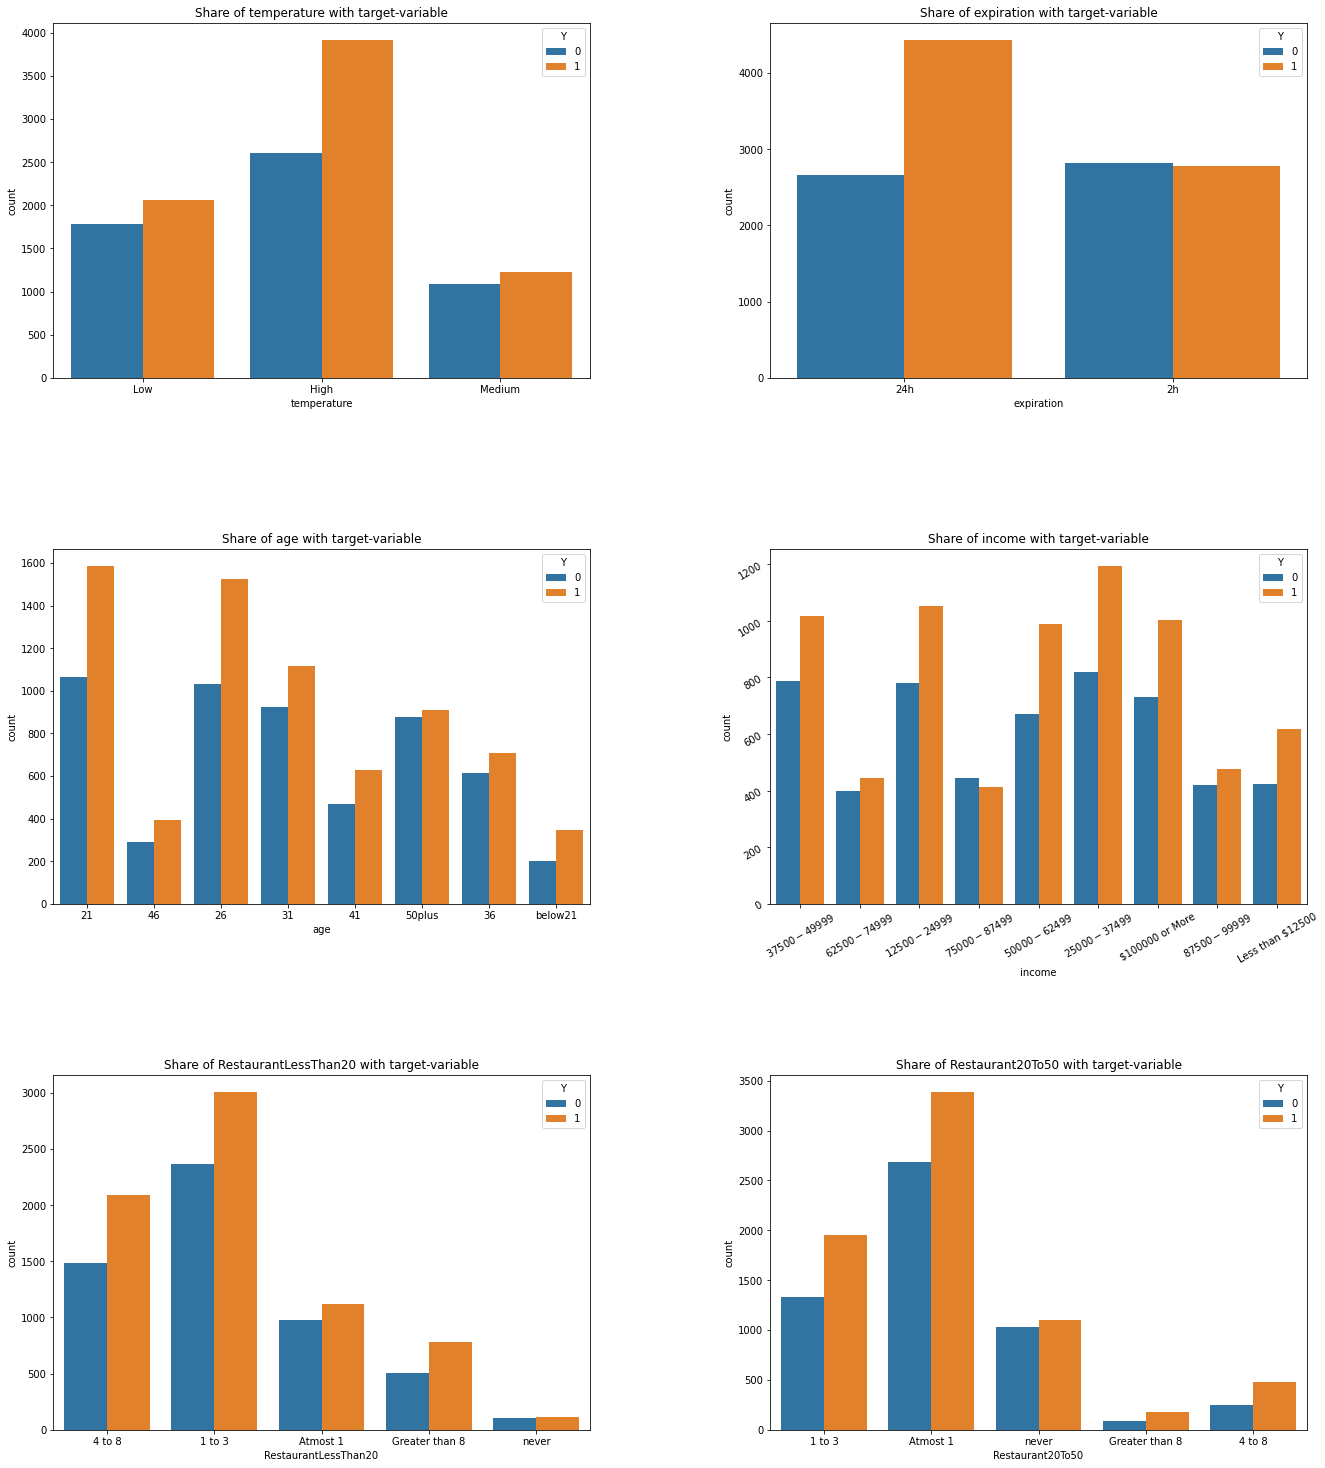

In [ ]:
def freq_with_target(nrows,ncols,figsize,cols_to_plot,subplot_to_rotate='',rotate_labels=False,deg=30,sharex=False,sharey=False):

    '''
    Helper function to see behaviour of attributes with target variable
    '''
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize,sharex=sharex,sharey=sharey)
    ax = ax.flatten()
    # increase space for large ticklabels
    if rotate_labels:
        fig.tight_layout(pad=15.0)
    i = 0
    for col in df.columns:
        if col in cols_to_plot and col!='Y':
            sns.countplot(x=col,data=df,ax=ax[i],hue='Y')
            ax[i].set_title('Share of {} with target-variable'.format(col))
            # rotation is needed wherever tick-labels are large
            if rotate_labels and col==subplot_to_rotate:
                ax[i].tick_params(labelrotation=deg)   #https://stackoverflow.com/a/52461208
            i += 1


freq_with_target(nrows=3, ncols=2,figsize=(22,24),cols_to_plot=ordinal_columns,subplot_to_rotate='income',rotate_labels=True)

We don't see much interesting things from the above plot as values are mostly uniformly distributed for each class. however some obervations:
* More Coupon acceptance rate for respondents in regions with high temperature 
* There is more acceptance of coupons where coupon expires in a day as compared to coupons which expire early in 2hrs. Reason is common-sensical that people have more time.
* Coupon is mostly accepted throughout all age and income groups. Moreover for both cheap and expensive restaurants irrespective of how many times an individual generally goes to these restaurants per month, he/she is more likely to accept the coupon.   

---


Since we have class-imbalance (Reject(0)\~5k & Accept(1)\~7k), this behaviour was more or less expected.

EDA of Nominal attributes

Q. What is the Frequency distribution of various nominal features

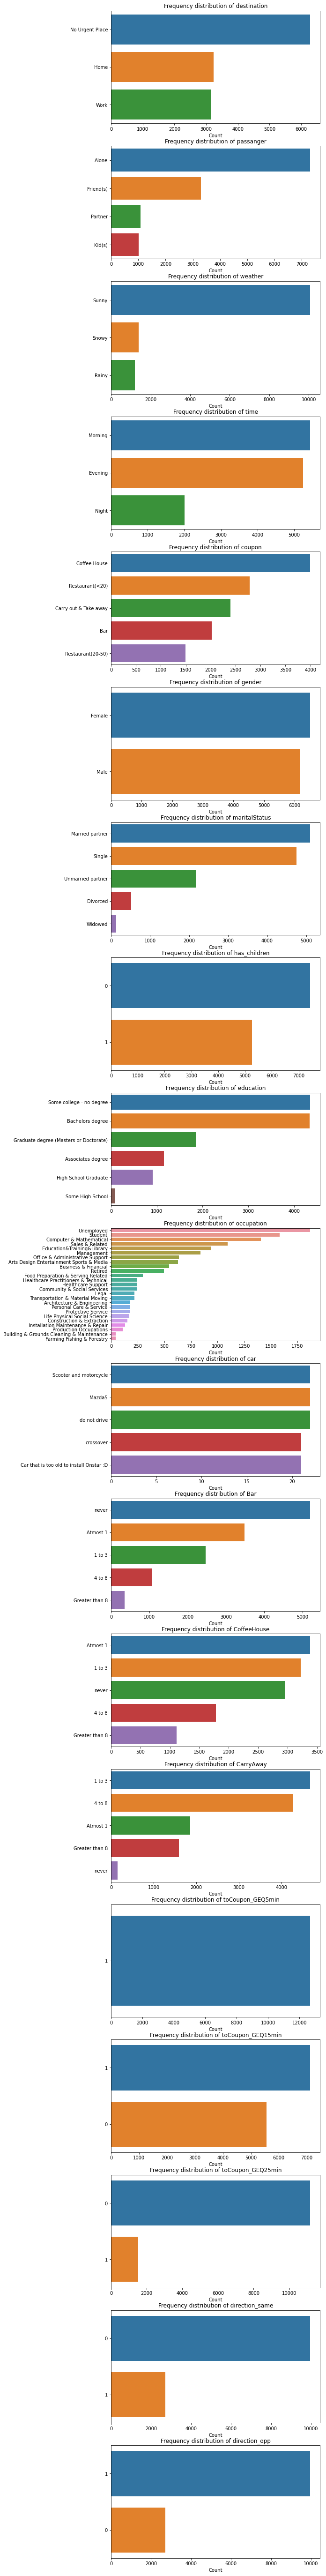

In [ ]:
Nominal_columns = set(df.columns) - set(ordinal_columns)  # storing all nominal columns
nrows = len(Nominal_columns) - 1  # excluding 'Y' variable hence -1
ncols = 1
figsize = (8,100)

freq_plotter(nrows,ncols,figsize,Nominal_columns)

Above are the Countplots for all the nominal variabes.    
* Most respondents are either Alone or with Friends. Weather is mostly Sunny and time attribute is majorly Morning & Evening that explains why temperature attribute was High category for most of the data.    
* Coffee-house coupons are offered the most followed by cheap restaurants.
* Most people were married or single with majority having no-kids.
* Education level has highest frequency of users who are either pursuing college or have Bachelors as their highest degree. This supports the frequency distribution of `Occupation` attribute which has Unemployed and Student as top-2 most frequent categories.
* We can't say about distribution of car as more than 99% of data is missing.
* After looking at how often people go to different venues each month, most people preferred CarryAway/takeaways over Bars & Coffee-houses. Probably because the former is quicker in process and most people have never been to a Bar.
* `tocoupon_GEQ5min` has only one value, hence has no variance in it's values at all and won't be suitable for predicting. It has just one value because all the venues will be atleast at 5mins of driving distance from driver's current location. Also, columns `tocoupon_GEQ15min` and `tocoupon_GEQ25min` can be combined with this column(using simple if-else) to make just one column for driving-distance which will make more sense.
* The `direction_same` and `direction_opp` have similar countplots with opposite labels. Infact they are perfectly correlated as the driver can be either in direction of venue OR the opposite direction. Hence 1 in one column will lead to 0 in the other. One of them can safely be dropped.

Q. How are these nominal variables related to target?

`Note` :- For interpretability purposes we won't plot all attributes (19) together in a single grid 

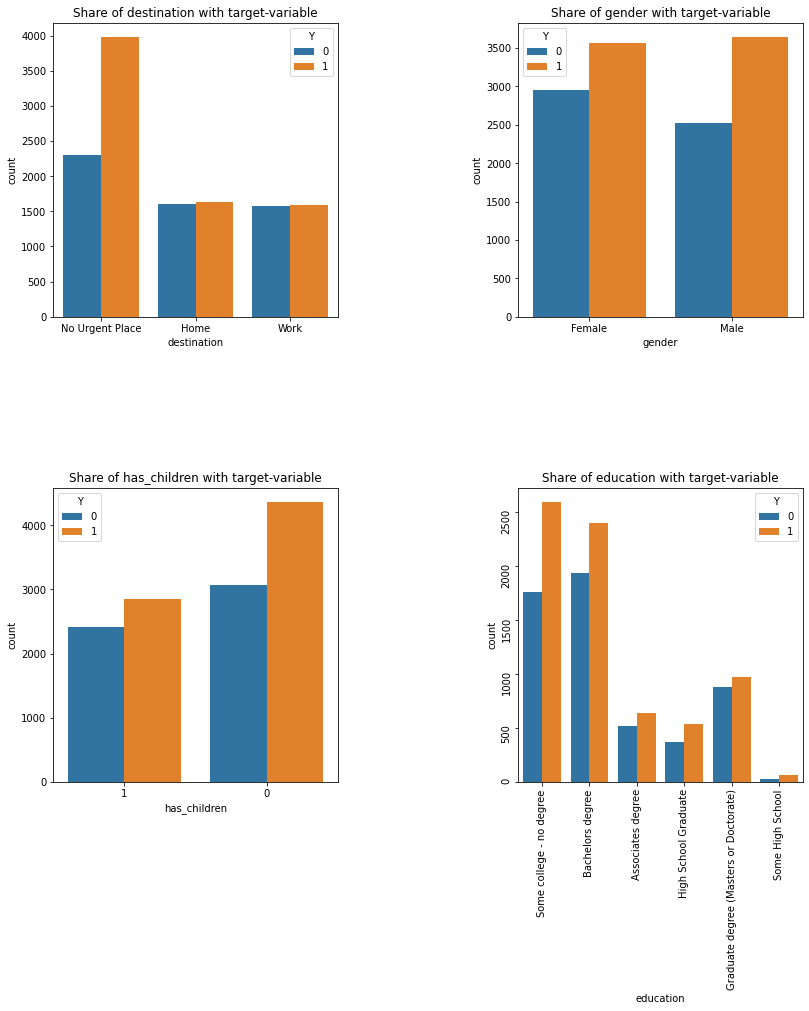

In [ ]:
# let's plot 4 together
freq_with_target(nrows=2, ncols=2,figsize=(15,15),cols_to_plot=['education', 'has_children', 'destination', 'gender'],subplot_to_rotate='education',rotate_labels=True,deg=90)

Observations:
* People who are pursuing a degree are the most frequent accepters of coupons followed by people who have a bachelors degree.
* People who have 0 children accept coupons more.
* People are more likely to accept coupons if they have no urgent place to visit, whereas if they are headed to home or work there is \~50% chance of accepting or rejecting
* Acceptance of coupons in male is slightly higher.

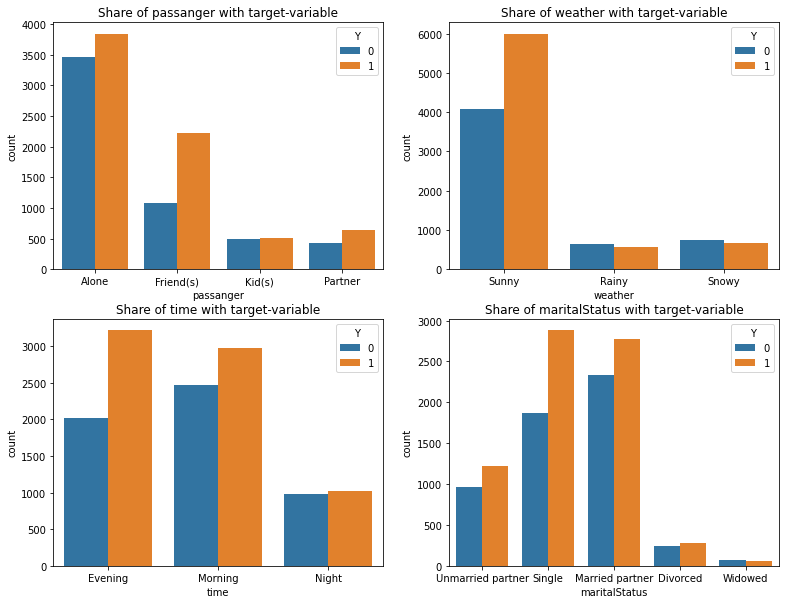

In [ ]:
freq_with_target(nrows=2, ncols=2,figsize=(13,10),cols_to_plot=['passanger', 'weather','maritalStatus' , 'time'])

Observations:
People are accepting more coupons if:
* They are driving with friends
* Weather is Sunny
* They are Single ,followed by Married
* They are travelling during Evening.  

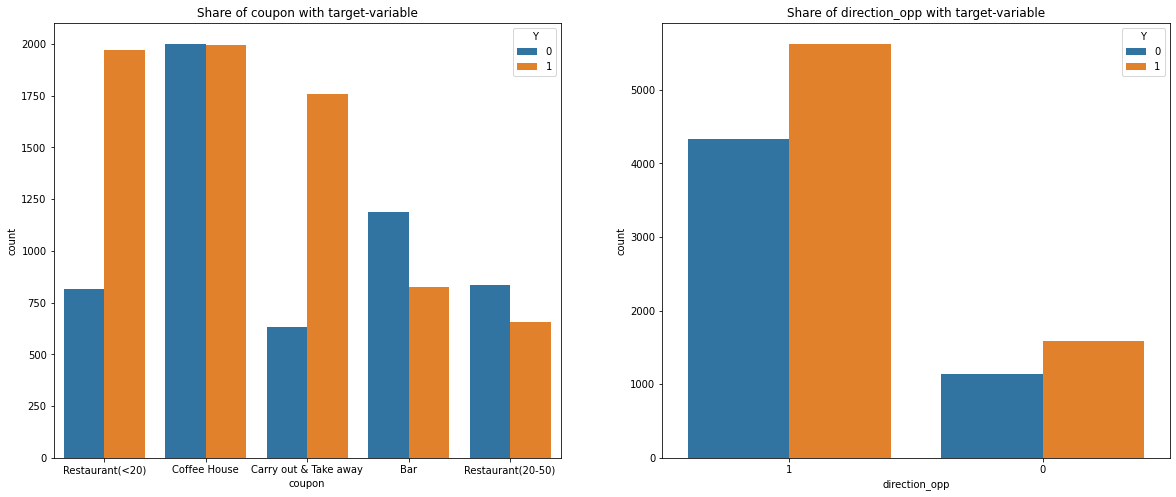

In [ ]:
freq_with_target(nrows=1, ncols=2,figsize=(20,8),cols_to_plot= ['direction_opp', 'coupon'])

Observations:
* Whether the user is in the same direction or not seem to not have a lot of effect on his/her decision. (The bars for label 1(opposite direction) is higher but that is only due to difference in scale/counts and relative difference for both labels(opposite or not) is almost same).     
* Cheap restaurants and carry-away coupons are the ones which people prefre the most. Coffee-house coupons are equally rejected and accepted. People don't prefer Bars and expensive restaurants coupons.

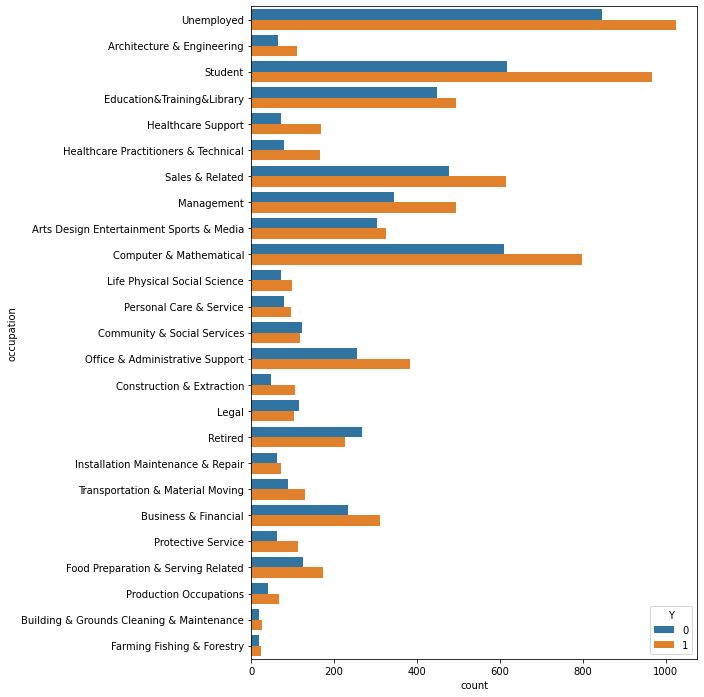

In [ ]:
# plotting occupation separately as a single plot due to high cardinality
plt.figure(figsize=(8,12))
sns.countplot(y="occupation",hue='Y',data=df)
plt.show()

People from all backgrounds are seen accepting the coupons more often. Students in particular have the highest coupon acceptance rate.

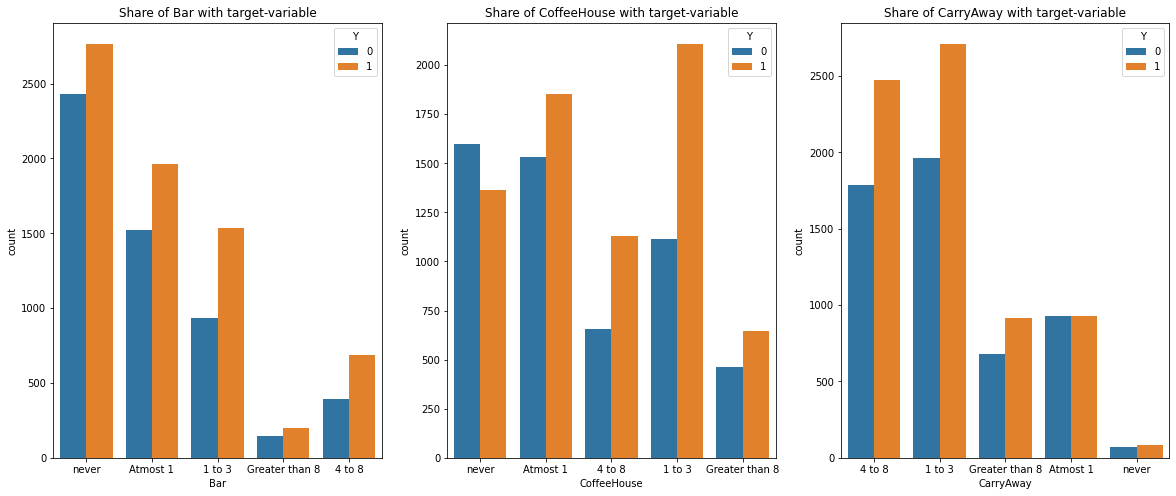

In [ ]:
freq_with_target(nrows=1, ncols=3,figsize=(20,8),cols_to_plot= ['Bar', 'CarryAway', 'CoffeeHouse'])

For Bars and carryaways people are generally accepting coupons.Even those who have never been to one.    
For coffeehouses people who have never been to one are not accepting the coupons whereas it increases for people who are more frequent-goers. Especially who go 1-3 times a month

Q. Are people accepting coupons of venues that they already visit frequently? In simple words if they have a general interest in a particular venue then will they accept it's coupon?

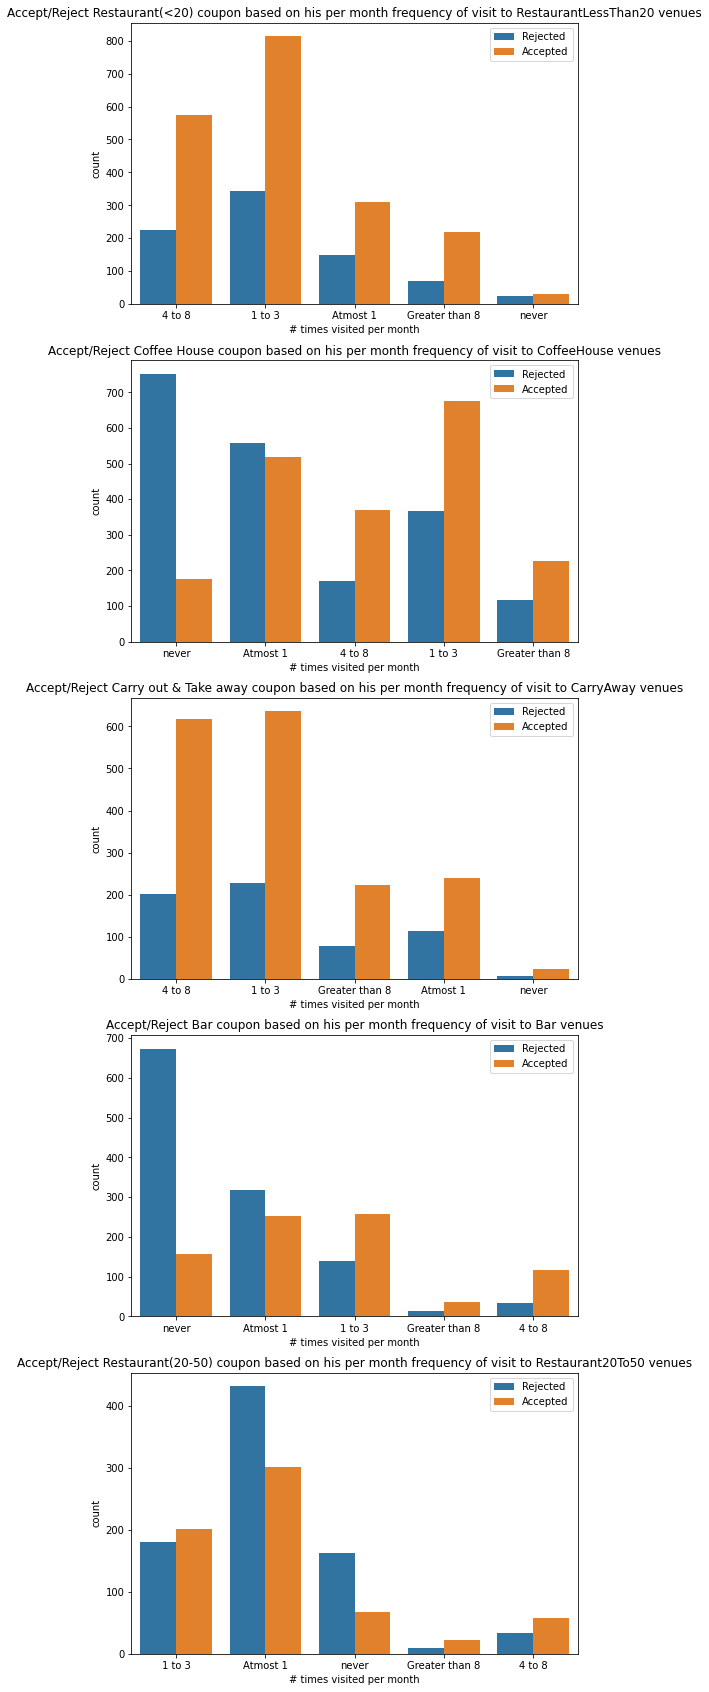

In [ ]:
# corresponding venue and it's coupon
venue_preference = ['RestaurantLessThan20', 'CoffeeHouse', 'CarryAway','Bar','Restaurant20To50']
coupon = ['Restaurant(<20)', 'Coffee House', 'Carry out & Take away', 'Bar',
       'Restaurant(20-50)']

fig,ax = plt.subplots(nrows=5, ncols=1,figsize=(8,30))
ax = ax.flatten()
for v,c,axes in zip(venue_preference,coupon,ax):
    temp = df[df['coupon']==c][[v,'Y']]  # taking only rows where we have coupon of the respective venue and then checking acceptance rates
    sns.countplot(x=v,hue='Y',data=temp,ax=axes)
    axes.set_title("Accept/Reject {} coupon based on his per month frequency of visit to {} venues".format(c,v))
    axes.set_xlabel("# times visited per month")
    axes.legend(labels=['Rejected','Accepted'])   

We can clearly see from the above plots that there is a general trend that people who are frequent goers of a venue will accept their discount coupons. Even people who go a few times (1 to 3) will accept the coupons more and probably increase their frequency of going.  
Observations:
* For cheap restaurants we can see there are very few people who never visited one and almost everyone accepts the cheap restaurant coupons more often than not.
* For coffee-houses people who have visited atmost 1 times or never visited have rejected the coffeehouse coupons more.
* For Carryaway coupons, since it's a quick grab, most people accept the coupons.
* Similarly in Bars we can see people who have visited atleast more than 1 are accepting the Bar discount coupon more often.
* For expensive restaurants people are generally not accepting coupons, only the more frequent ones (>1 times a month) are more likely to accept the expensive-restaurant-coupons. Probably because even after the discount the food wouldn't fit the budget.

#### Exploratory Data Analysis (Bivariate)
Based on above EDA and domain knowledge let's try some feature combinations to detect if they yield any trend in target

In [ ]:
# We'll need a temporary copy as we wanna make some changes to data
temp = df.copy()

In [ ]:

def plot_bivariate(f1,f2,temp,rotate_ticks=False,deg=90):

    '''
    Helper function to see if any bivariate relatonships in data are helping us i detecting any trends in categorical data
    '''

    temp['feature_comb'] = temp[f1].astype('str') + ' & ' + temp[f2].astype('str') 
    sns.countplot(x='feature_comb',hue='Y',data=temp)
    plt.xlabel("Combination of {} & {}".format(f1,f2))
    plt.title("Effect of {} & {} on target variable".format(f1,f2))
    plt.ylabel("")
    if rotate_ticks:
        plt.xticks(rotation=deg)
    plt.legend(labels=['Rejected','Accepted'])
    plt.show()


Q. Does these combinations of features together have an effect on acceptance of coupons?

1) temperature and weather

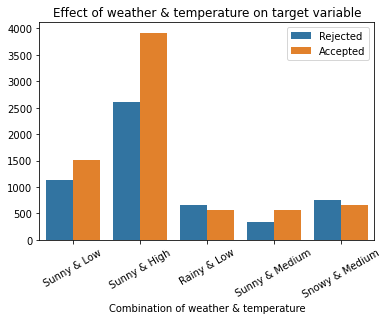

In [ ]:
plot_bivariate('weather', 'temperature',temp,rotate_ticks=True,deg=30)

Observation : People are accepting more coupons if overall climate is on the higher side

2) Passenger and destination

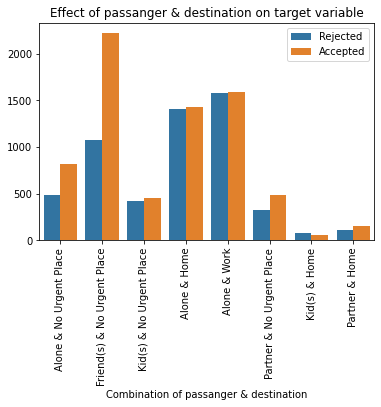

In [ ]:
plot_bivariate('passanger', 'destination',temp,rotate_ticks=True,deg=90)

Observations: 
* Coupon acceptance is most if people are with friends and have no urgent place to go to.   
* It is also high if people are alone or with partner but there destination should be no urgent place.

3) Destination and direction_same (1 | 0)

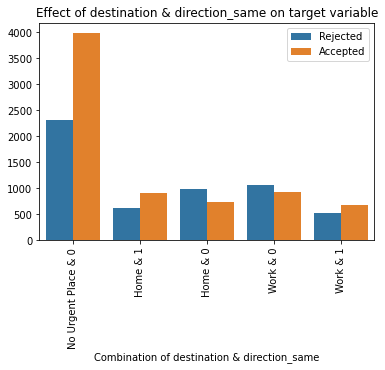

In [ ]:
plot_bivariate('destination', 'direction_same',temp,rotate_ticks=True,deg=90)

Observations:
* As already seen above if people have no urgent place to go they are accepting the coupons even if they are moving in opposite direction of the coupon venue.
* Interestingly if people are in the same direction of the venue, irrespective of whether they are headed to work or home, then they are more likley to accept the coupon as compared to if they are moving in opposite direction.  

4) Gender and time

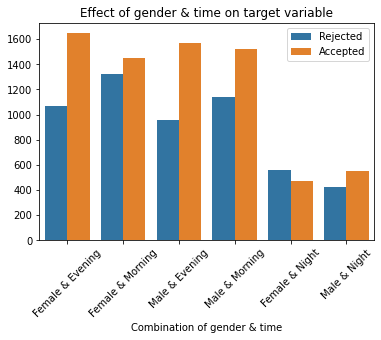

In [ ]:
plot_bivariate('gender', 'time',temp,rotate_ticks=True,deg=45)

Observations: 
* In morning, Male are more likely to accept the coupon.
* In evening, both male and female are accepting the coupons more often
* At night, male are more likely than female to accept the coupons.

#### Data preprocessing

From the EDA we decided to make a few changes to the data like dropping and combining columns

In [ ]:
# let's drop direction_same as it's perfectly correlated with direction_opp
df.drop('direction_same',axis=1,inplace=True)



Also we'll combine toCoupon_GEQ5min , toCoupon_GEQ15min & toCoupon_GEQ25min into one.   
We'll drop these 3 after creating a driving distance column which will have these 3 distances as categorical values.

In [ ]:
def custom_where(ele):
    '''
    Helper function to combine 3 redundant columns into 1 using simple if-else
    '''

    x,y,z = list(map(str,ele))
    if x == '1':
        if y=='1':
            if z=='1':
                return 'within 25mins'
            else:
                return 'within 15mins'
        else:
            return 'within 5mins'

In [ ]:
df['driving_distance'] = df[['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min']].apply(custom_where,axis=1,raw=True)
df.drop(['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min'],axis=1,inplace=True)

Q. Let's check effect of this newly created variable 'driving_distance' on Target_variable 

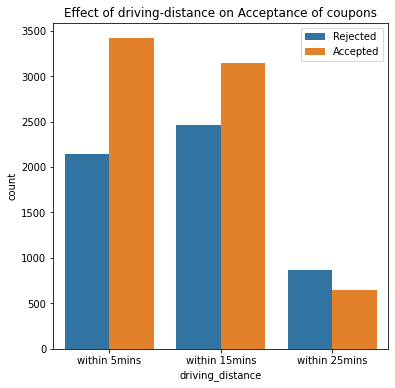

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(x='driving_distance',data=df,hue='Y')
plt.title("Effect of driving-distance on Acceptance of coupons")
plt.legend(labels=['Rejected','Accepted'])
plt.show()

It's clearly evident from the above plot that there is an inverse relationship between coupon acceptance and time to reach the venue. Hence, people are seen accepting discount coupons if the venue is near them (within 5mins or 15mins) and it decreases as time to reach there increases (more rejection for within 25mins).

#### Missing value imputation

We luckily don't have a lot of missing values apart from the `Car` variable, sow we'll impute everything else with most frequent category and car attribute wil be given a value 'missing' for NAN's.    
We can try other techniques as well here, if model performance is affected we can try those as well but as not a lot of data is missing we will go with this for now.

In [ ]:
def mis_val_imputer(cols_to_impute,df):
    ''' Impute missing values with most frequent category '''

    for col in cols_to_impute:
        most_frequent_val = df.iloc[:,col].mode()[0]
        df.iloc[:,col].fillna(most_frequent_val,inplace=True)
    
    return df

In [ ]:
df.car.fillna('Missing',inplace=True)  # filling car
nulls = np.nonzero(df.isnull().sum().values)[0]   # get all columns indices with NAN's
df = mis_val_imputer(nulls,df)

In [ ]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
car                     0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
direction_opp           0
Y                       0
driving_distance        0
dtype: int64

In [ ]:
df.to_csv('Preprocessed_data.csv',index=False)

#### Exploratory Data Analysis (Multivariate Analysis using Decision-Tree)

In [ ]:
def multivariate_analysis(df):

    '''
    Helper function to perform multivariate analysis using simple Decision Tree nad interpreting it's feature combinations.

    Simple feature encoding techniques like OHE and Label-encoding is done here, as we are concerned with only interpretation here and not performance
    '''

    # ordinal encodings borrowed from --> https://www.kaggle.com/iyet1killer/classification-on-categorical-data-part-1-sklearn
    
    d_time = {
    '7AM':'Morning',
    '10AM':'Morning',
    '2PM':'Evening',
    '6PM':'Evening',
    '10PM':'Night'}
    d = {
            'never': 0,
            'less1': 1,
            '1~3': 2,
            '4~8': 3,
            'gt8': 4}
    age_map = {
            'below21': 0,
            '21': 1,
            '26': 2,
            '31': 3,
            '36': 4,
            '41': 5,
            '46': 6,
            '50plus': 7}
    income_map = {
            'Less than $12500': 0,
            '$12500 - $24999': 1,
            '$25000 - $37499': 2,
            '$37500 - $49999': 3,
            '$50000 - $62499': 4,
            '$62500 - $74999': 5,
            '$75000 - $87499': 6,
            '$87500 - $99999': 7,
            '$100000 or More': 8}
    cols_that_need_wrangling = ['Restaurant20To50', 'RestaurantLessThan20', 'CarryAway', 'CoffeeHouse', 'Bar']

    # label encode
    for column in cols_that_need_wrangling:
        df[column] = df[column].map(d)

    df['driving_distance'] = df[['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min']].apply(custom_where,axis=1,raw=True)

    df.drop(['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min','direction_same','car'],axis=1,inplace=True)
    df.income = df.income.map(income_map)
    df.age = df.age.map(age_map)
    df.time = df.time.map(d_time)

    nulls = np.nonzero(df.isnull().sum().values)[0]   # get all columns indices with NAN's

    df = mis_val_imputer(nulls,df)

    # label encode
    df.driving_distance = df.driving_distance.map({
        'within 5mins':1, 'within 15mins':2, 'within 25mins':3
    })

    # one hot encoding columns
    ohe_cols = df.dtypes[df.dtypes==object].index.values
    encoded_df = pd.get_dummies(df, columns=ohe_cols)

    # taking X,y for building tree on our data 
    y = encoded_df.Y
    encoded_df.drop('Y',axis=1,inplace=True)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.33, random_state=42)

    # we're only concerned with Train data as we just want to see if we can get good feature-combinations
    clf_dt = DecisionTreeClassifier(criterion='entropy',random_state=0,max_depth=4)  # 4 depth for interpretability purposes
    clf_dt.fit(X_train,y_train)

    return clf_dt,X_train

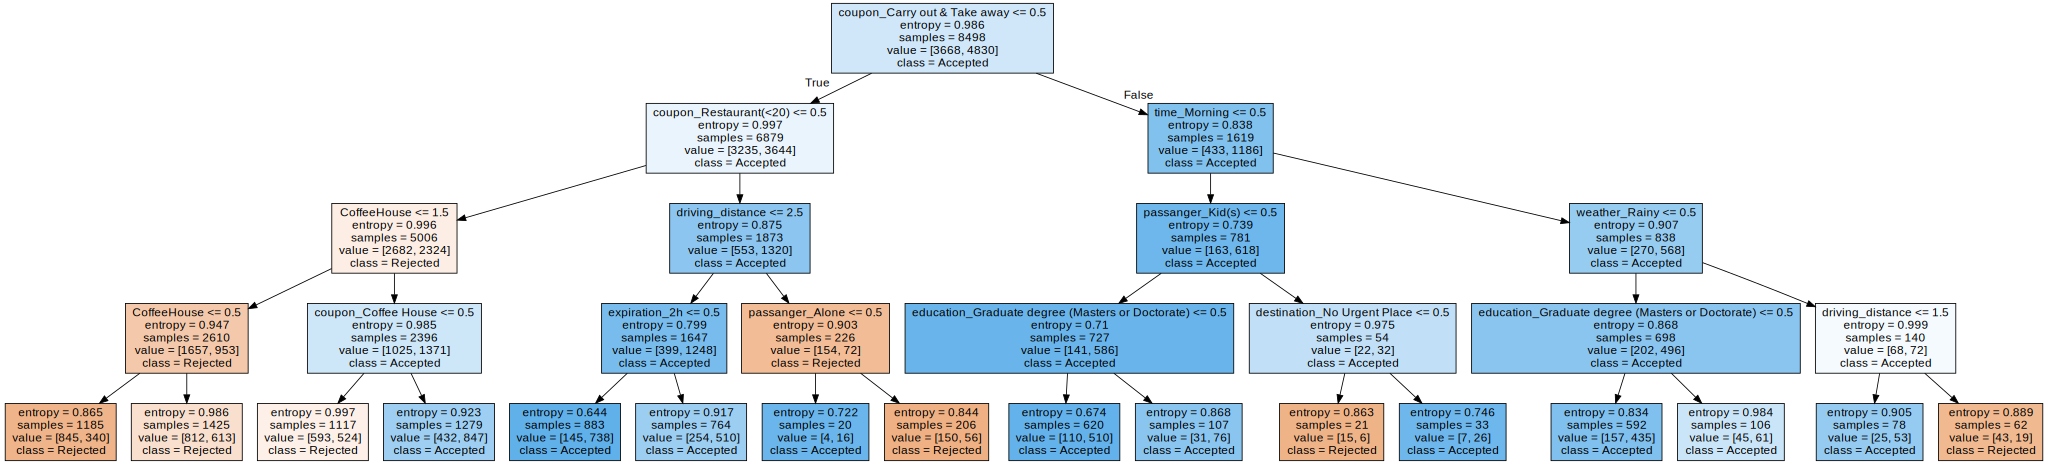

In [ ]:
# plot tree using graphviz
data = pd.read_csv('/content/drive/MyDrive/Datasets/in-vehicle-coupon-recommendation.csv')
clf1,data = multivariate_analysis(data)

Source(tree.export_graphviz(clf1,
                     out_file=None,
                     class_names=['Rejected','Accepted'],
                     feature_names = data.columns,
                     filled = True))


In [ ]:
# check feature importances
pd.DataFrame(np.c_[clf1.feature_names_in_,clf1.feature_importances_],columns=['Features','Importances']).sort_values(by='Importances',ascending=False)

,Features,Importances
28,coupon_Restaurant(<20),0.253692
5,CoffeeHouse,0.214515
25,coupon_Carry out & Take away,0.178886
10,driving_distance,0.145329
26,coupon_Coffee House,0.071271
...,...,...
1,age,0.0
35,maritalStatus_Single,0.0
36,maritalStatus_Unmarried partner,0.0
37,maritalStatus_Widowed,0.0


Now based on the above interpretation of model we'll try a few combinations

In [ ]:
# As we'll need to make temporary changes to data for easy plotting.
temp = df.copy()

`PLOT-1` : Let's plot combining features 'coupon-type' + 'expiration-time' + 'driving-distance'

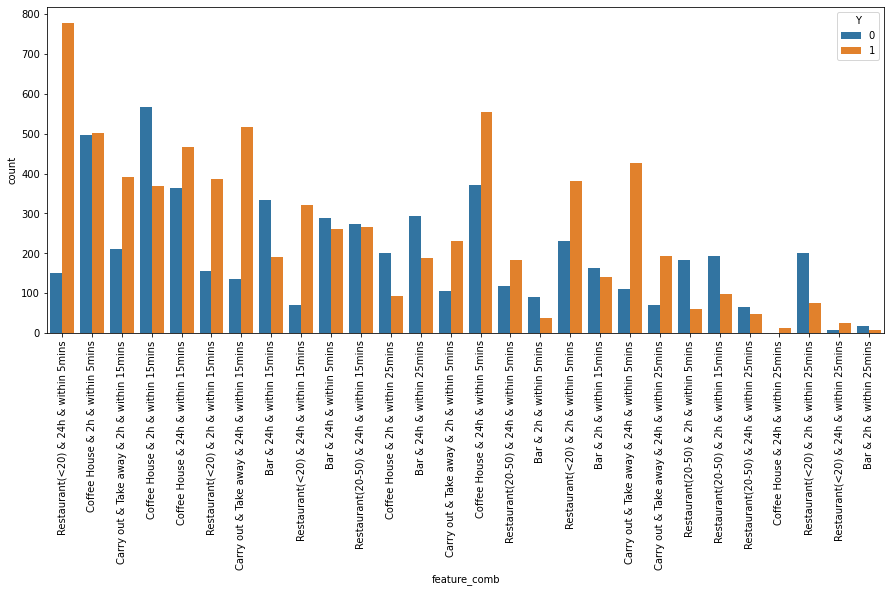

In [ ]:
temp['feature_comb'] = temp['coupon'] + ' & ' + temp['expiration'] + ' & ' + temp['driving_distance']
plt.figure(figsize=(15,6))
sns.countplot(x='feature_comb',hue='Y',data=temp)
plt.xticks(rotation=90)
plt.show()

A few Obsevations from here:
* Generally people are accepting Cheap restraunts and carry-outs coupons. This is something we saw in univariate analysis as well. But we also see here that as expiration time decreases and driving-distance increases, Cheap restraunts coupons rejection rate increase dramatically.
* For coffeehouse coupons, in univariate analysis we saw that acceptance and rejection rate is almost equal. Here we see that if expiration time is 24h and driving-distance decreases then there is more acceptance of coffeehouse coupons. Same strategy could work for Expensive restaurants as well.
* For Bars, people are mostly rejecting.

`PLOT-2` : Since most of the coupons handed out are coffee-house ones, we should try to inspect more. Let's plot combining features 'coupon-type' + 'passenger' + 'driving-distance' only for coffeehouses

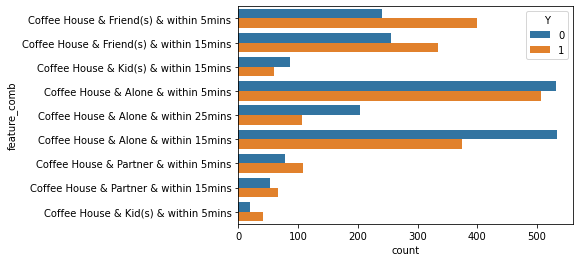

In [ ]:
temp['feature_comb'] = temp['coupon'] + ' & ' +temp['passanger'] + ' & ' + temp['driving_distance']
data = temp[temp['coupon']=='Coffee House']
sns.countplot(y='feature_comb',hue='Y',data=data)
plt.show()


* People are more likely to go to coffee-houses when with friends/partner as compared to alone

`PLOT-3` : Let's plot combining features 'coupon-type' + 'time of day' + 'driving-distance' for each venue's coupon separately

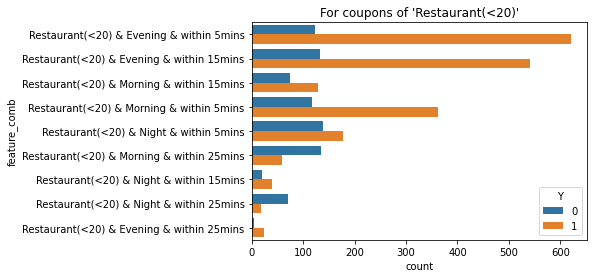

----------------------------------------------------------------------------------------------------------------------------------


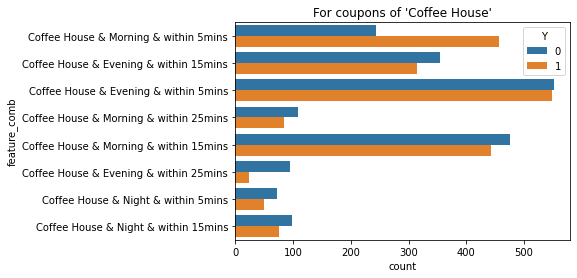

----------------------------------------------------------------------------------------------------------------------------------


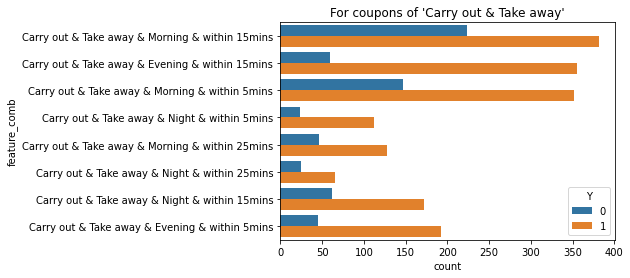

----------------------------------------------------------------------------------------------------------------------------------


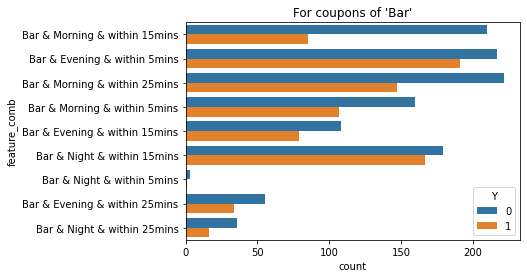

----------------------------------------------------------------------------------------------------------------------------------


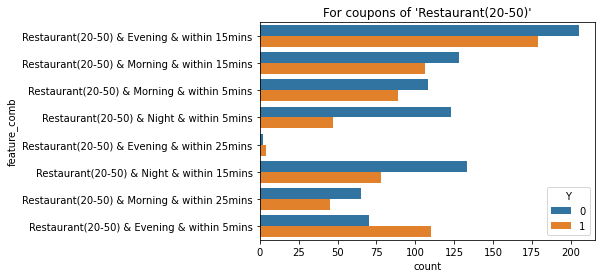

----------------------------------------------------------------------------------------------------------------------------------


In [ ]:
temp['feature_comb'] = temp['coupon'] + ' & ' +temp['time'] + ' & ' + temp['driving_distance']

# let's show for each coupon for interpretability
for cp in temp.coupon.unique():
    data = temp[temp['coupon']==cp]
    sns.countplot(y='feature_comb',hue='Y',data=data)
    plt.title("For coupons of \'{}\'".format(cp))
    plt.show()
    print('-'*130)

Observations
* Nearby Restaurants coupon should be handed out in evening and coffeehouse's at morning.
* Bar at night (however for strong conclusions on bar, we'll need more data as in this data bar's coupon are mostly rejected) and carryout coupons can be given out anytime.

#### Performance Metric

1) `EDA of target` - Our Target variable has around 57% accepted (1) labels and 43% rejected (0) labels so imbalance is not a large problem.   
2) `Business contraints` :- We want to help local businesses (coffe-houses,restaurants etc.) understand which customers to target for their promotions while also minimizing their cost of promotions. This will help them maximize their revenue(and profits).    
3) `Mapping to ML metric`: This is a simple Binary classification problem, our primary metric should be **F1-Score** : Because we want *Higher-Precision* as we want to optimize the cost of promotional marketing and to some extent also not hurt customer-experience & *Higher-Recall* as we want to increase the revenue as much as possible so we shoudn't miss out on potential customers.   
4) `Secondary ML metric`: We can use AUC as secondary metric which will tell how discriminative my model is between classes.


#### END